In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("../project_two-master/data/microprocessor-clock-speed.csv")

In [3]:
data = data.rename(columns={'Microprocessor clock speed (Hertz (pulses per second))':'Pulses'})

In [4]:
data = data.set_index('Year')

In [5]:
data.head()

,Entity,Code,Pulses
Year,,,
1976,World,OWID_WRL,1350000
1977,World,OWID_WRL,2060000
1978,World,OWID_WRL,2140000
1979,World,OWID_WRL,2290000
1980,World,OWID_WRL,1940000


In [6]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
# Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [7]:
# creating new dataframe from consumption column
data_consumption = data[['Pulses']]
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'Pulses'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
# dropping NAs
data_consumption = data_consumption.dropna()

/Users/jtst/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jtst/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
data_consumption.head()

,Pulses,Yesterday,Yesterday_Diff
Year,,,
1978,2140000,2060000.0,710000.0
1979,2290000,2140000.0,80000.0
1980,1940000,2290000.0,150000.0
1981,2410000,1940000.0,-350000.0
1982,2630000,2410000.0,470000.0


In [9]:
X = data_consumption.drop(['Pulses'], axis = 1)
y = data_consumption['Pulses']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

LR: -439.415707 (1286.300635)
NN: 0.784382 (0.399520)
RF: -3716.964552 (11152.742862)
SVR: -56095.327167 (168229.536431)


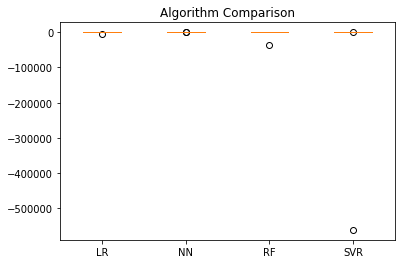

In [12]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
#models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [13]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [14]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [15]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.2806
mean_squared_log_error:  0.7452
r2:  0.1614
MAE:  1325282925.1736
MSE:  5.175732752676884e+18
RMSE:  2275023681.7837


In [16]:
# creating copy of original dataframe
data_consumption_2o = data_consumption.copy()
# inserting column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption_2o['Yesterday-1_Diff'] = data_consumption_2o['Yesterday-1'].diff()
# dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

In [17]:
data_consumption_2o.head()

,Pulses,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
Year,,,,,
1980,1940000,2290000.0,150000.0,2140000.0,80000.0
1981,2410000,1940000.0,-350000.0,2290000.0,150000.0
1982,2630000,2410000.0,470000.0,1940000.0,-350000.0
1983,4070000,2630000.0,220000.0,2410000.0,470000.0
1984,5190000,4070000.0,1440000.0,2630000.0,220000.0


In [18]:
X2 = data_consumption_2o.drop(['Pulses'], axis = 1)
y2 = data_consumption_2o['Pulses']

In [19]:
X_train_2o, X_test_2o, y_train_2o, y_test_2o = train_test_split(X2, y2, random_state=1)

In [20]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true2 = y_test_2o.values
y_pred2 = best_model.predict(X_test_2o)
regression_results(y_true2, y_pred2)

explained_variance:  0.7523
mean_squared_log_error:  0.5233
r2:  0.7356
MAE:  678654966.2946
MSE:  1.2408789506165773e+18
RMSE:  1113947463.1313


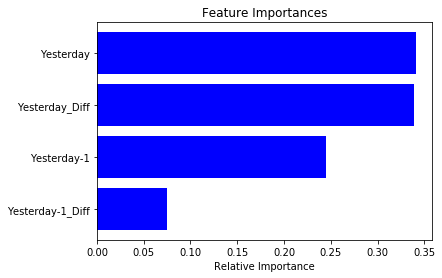

In [21]:
imp = best_model.feature_importances_
features = X_train_2o.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
data_consumption_2o_weeklyShift = data_consumption_2o.copy()
data_consumption_2o_weeklyShift['Last_Week'] = data_consumption_2o['Pulses'].shift(7)
data_consumption_2o_weeklyShift = data_consumption_2o_weeklyShift.dropna()

In [23]:
data_consumption_2o_weeklyShift.head()

,Pulses,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Last_Week
Year,,,,,,
1987,9430000,7210000.0,1320000.0,5890000.0,700000.0,1940000.0
1988,12660000,9430000.0,2220000.0,7210000.0,1320000.0,2410000.0
1989,15630000,12660000.0,3230000.0,9430000.0,2220000.0,2630000.0
1990,19440000,15630000.0,2970000.0,12660000.0,3230000.0,4070000.0
1991,21180000,19440000.0,3810000.0,15630000.0,2970000.0,5190000.0


In [24]:
X3 = data_consumption_2o_weeklyShift.drop(['Pulses'], axis = 1)
y3 = data_consumption_2o_weeklyShift['Pulses']

In [25]:
X_train_2o_weeklyShift, X_test_2o_weeklyShift, y_train_2o_weeklyShift, y_test_2o_weeklyShift = train_test_split(X3, y3, random_state=1)

In [26]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_weeklyShift, y_train_2o_weeklyShift)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true3 = y_test_2o_weeklyShift.values
y_pred3 = best_model.predict(X_test_2o_weeklyShift)
regression_results(y_true3, y_pred3)

explained_variance:  0.9783
mean_squared_log_error:  0.046
r2:  0.9309
MAE:  805527833.3333
MSE:  9.457229619495e+17
RMSE:  972482885.1705


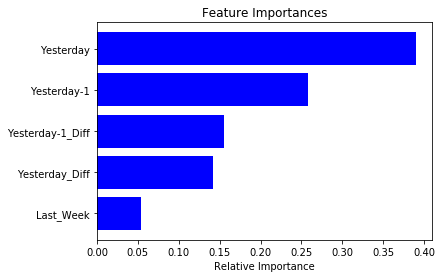

In [27]:
imp = best_model.feature_importances_
features = X_train_2o_weeklyShift.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()